In [ ]:
from cgeniepy.ecology import EcoModel
import xarray as xr
import numpy as np
from cgeniepy.array import GriddedData
GriddedData.modify_in_place=False
## plot pft richness maps
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cmap import Colormap
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

arctic_mask = xr.load_dataarray("../data/masked_array.nc")

def get_pft_richness(model):
    """
    Get the PFT richness for a given model and PFT index.
    """

    ## recalculate because foram use a different method
    qcarbon_a = model.get_config('ECOGEM')['qcarbon_a']
    qcarbon_b = model.get_config('ECOGEM')['qcarbon_b']
    volume = model.eco_pars()['volume']
    carbon_thresholds = qcarbon_a * volume ** qcarbon_b

    ## counting from 0
    phyto_index = np.arange(0,32)
    zoo_index = np.arange(32,64)
    mixo_index = np.arange(64,96)
    foram_index = np.arange(96,112)
    all_index=  [i for i in range(1,113)]

    ## diversity (no. of PFTs) map

    model_mask = model.grid_mask()
    pft_n = xr.zeros_like(model.get_pft(1).data) * model_mask
    extinction = np.ones(len(carbon_thresholds)) ## 1 means extinct

    phyto_rich, zoo_rich, mixo_rich, foram_rich = [], [], [], []

    for i in range(len(carbon_thresholds)):
        pft = model.get_pft(i+1)
        threshold = carbon_thresholds[i]    
        ## filter out the species with biomass less than threshold    
        pft_presence = xr.where(pft> threshold, 1, 0.0)
        if i in phyto_index:
            phyto_rich.append(pft_presence)
        elif i in zoo_index:
            zoo_rich.append(pft_presence)
        elif i in mixo_index:
            mixo_rich.append(pft_presence)
        elif i in foram_index:
            foram_rich.append(pft_presence)

        if pft_presence[-1].sum() > 0:
            extinction[i] = 0

    ## sum over PFT dimension
    phyto_rich = xr.concat(phyto_rich, dim='pft') * model_mask* arctic_mask
    zoo_rich = xr.concat(zoo_rich, dim='pft') * model_mask* arctic_mask
    mixo_rich = xr.concat(mixo_rich, dim='pft')* model_mask* arctic_mask
    foram_rich = xr.concat(foram_rich, dim='pft')*model_mask* arctic_mask
    total_pft = phyto_rich.sum(dim='pft') + zoo_rich.sum(dim='pft') +mixo_rich.sum(dim='pft') +foram_rich.sum(dim='pft')

    total_pft = total_pft *model_mask * arctic_mask
    total_pft = GriddedData(total_pft, attrs={'long_name': 'No. PFTs',  'units': ''})
    survivor_rate = (total_pft / total_pft[0]) * 100
    survivor_rate.attrs['long_name'] = 'percentage'

    total_pft_timeseries = count_unique_pfts(phyto_rich) + count_unique_pfts(zoo_rich) + \
        count_unique_pfts(mixo_rich) + count_unique_pfts(foram_rich)

    return total_pft, survivor_rate, total_pft_timeseries

def count_unique_pfts(data):
    # Sum across spatial dimensions (lat, lon) to get total abundance per PFT per time
    pft_time_sums = data.sum(dim=['lat', 'lon'])
    
    # Create a boolean mask where PFT is present (abundance > 0)
    pft_present = (pft_time_sums > 0)
    
    # Sum the boolean mask along PFT dimension to get count of unique PFTs
    unique_pft_counts = pft_present.sum(dim='pft')
    
    return unique_pft_counts

In [30]:
model_ctrl = EcoModel("../model/muffin.u067bc.PO4Fe.main/", gemflag=['biogem', 'ecogem'])
model_e01 = EcoModel("../model/muffin.u067bc.PO4Fe.main.ll/", gemflag=['biogem', 'ecogem'])
model_e2 = EcoModel("../model/muffin.u067bc.PO4Fe.main.nl/", gemflag=['biogem', 'ecogem'])
model_e5 = EcoModel("../model/muffin.u067bc.PO4Fe.main.ml/", gemflag=['biogem', 'ecogem'])
model_e10 = EcoModel("../model/muffin.u067bc.PO4Fe.main.ul/", gemflag=['biogem', 'ecogem'])

total_pft1, survivor_rate1, unique_pft_timeseries1 = get_pft_richness(model_ctrl)
total_pft2, survivor_rate2, unique_pft_timeseries2 = get_pft_richness(model_e01)
total_pft3, survivor_rate3, unique_pft_timeseries3 = get_pft_richness(model_e2)
total_pft4, survivor_rate4, unique_pft_timeseries4 = get_pft_richness(model_e5)
total_pft5, survivor_rate5, unique_pft_timeseries5 = get_pft_richness(model_e10)

In [33]:
# show all the unique PFTs
print(unique_pft_timeseries1[-1]/unique_pft_timeseries1[1] * 100)
print(unique_pft_timeseries2[-1]/unique_pft_timeseries2[1] * 100)
print(unique_pft_timeseries3[-1]/unique_pft_timeseries3[1] * 100)
print(unique_pft_timeseries4[-1]/unique_pft_timeseries4[1] * 100)
print(unique_pft_timeseries5[-1]/unique_pft_timeseries5[1] * 100)

<xarray.DataArray ()> Size: 8B
array(22.22222222)
<xarray.DataArray ()> Size: 8B
array(22.22222222)
<xarray.DataArray ()> Size: 8B
array(18.18181818)
<xarray.DataArray ()> Size: 8B
array(14.14141414)
<xarray.DataArray ()> Size: 8B
array(8.24742268)


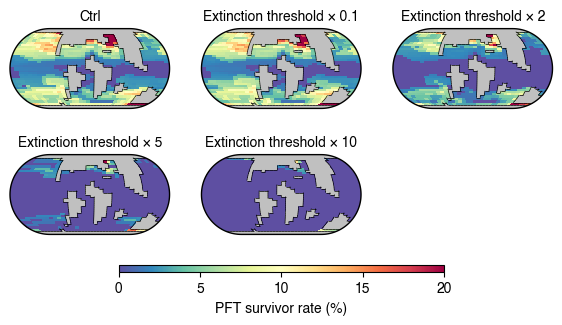

In [28]:
fig, axs = plt.subplots(2,3, subplot_kw={'projection': ccrs.EckertIV()}, figsize=(7, 4))
## set font
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Helvetica'

cmap="Spectral_r"

p = survivor_rate1.isel(time=-1).plot(ax=axs[0, 0], cmap=cmap, colorbar=False, outline=True, vmax=20)
survivor_rate2.isel(time=-1).plot(ax=axs[0, 1], cmap=cmap, colorbar=False, outline=True, vmax=20)
survivor_rate3.isel(time=-1).plot(ax=axs[0, 2], cmap=cmap, colorbar=False, outline=True, vmax=20)
survivor_rate4.isel(time=-1).plot(ax=axs[1, 0], cmap=cmap, colorbar=False, outline=True, vmax=20)
survivor_rate5.isel(time=-1).plot(ax=axs[1, 1], cmap=cmap, colorbar=False, outline=True, vmax=20)

axs[0, 0].set_title('Ctrl', fontsize=10)
axs[0, 1].set_title('Extinction threshold × 0.1', fontsize=10)
axs[0, 2].set_title('Extinction threshold × 2', fontsize=10)
axs[1, 0].set_title('Extinction threshold × 5', fontsize=10)
axs[1, 1].set_title('Extinction threshold × 10', fontsize=10)
axs[1,2].set_visible(False)  # Hide the empty subplot

## add colorbar
cbar = fig.colorbar(p, ax=axs, orientation='horizontal', pad=0.1, aspect=50, shrink=0.6)
cbar.set_label('PFT survivor rate (%)')

fig.savefig('../output/sensitivity_thresholds.png', dpi=300, bbox_inches='tight')